## DFS

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
# load FanDuel players list and drop injury indicators
players = pd.read_csv('FanDuel-NFL-2022 ET-09 ET-08 ET-79963-players-list.csv')

# pare down columns
players = players[['Nickname', 'FPPG', 'Salary', 'Roster Position', 'Injury Indicator']]

print(players.shape)
players.head(3)

(1060, 5)


,Nickname,FPPG,Salary,Roster Position,Injury Indicator
0,Jonathan Taylor,20.770589,10200,RB/FLEX,NaN
1,Derrick Henry,21.833333,9700,RB/FLEX,NaN
2,Cooper Kupp,22.180952,9500,WR/FLEX,NaN


In [3]:
# load FantasyPros actuals by position
pos_actuals = []
keep_columns = ['Player', 'FPTS', 'Season', 'WeekNum']

for position in ['qb', 'rb', 'wr', 'te', 'dst']:
    start = datetime.now()
    temp = pd.read_excel('FantasyPros.xlsx', sheet_name = position)
    pos_actuals.append(temp[temp['G']!=0][keep_columns])
    stop = datetime.now()
    print(f'{temp.shape[0]} {position.upper()} lines loaded in {stop-start} seconds.')
    
actuals = pd.concat(pos_actuals)
actuals.head(3)

2984 QB lines loaded in 0:00:01.070594 seconds.
6704 RB lines loaded in 0:00:01.254841 seconds.
10427 WR lines loaded in 0:00:01.821689 seconds.
6095 TE lines loaded in 0:00:01.113717 seconds.
1090 DST lines loaded in 0:00:00.170081 seconds.


,Player,FPTS,Season,WeekNum
0,Kyler Murray (ARI),34.6,2021,1
1,Patrick Mahomes II (KC),33.3,2021,1
2,Jared Goff (DET),29.9,2021,1


In [4]:
# convert Fantasy Pros' Player to FanDuel's Nickname
actuals['Nickname'] = actuals['Player'].apply(lambda x: x[: x.find('(')-1])

# map names: Fantasy Pros --> FanDuel
name_map = {
    'Elijah Mitchell':'Eli Mitchell', 
    'Patrick Mahomes II':'Patrick Mahomes',
    'Duke Johnson Jr.':'Duke Johnson',
    'PJ Walker':'P.J. Walker',
    'Patrick Taylor Jr.':'Patrick Taylor',
    'Keelan Cole Sr.':'Keelan Cole',
    'Gabriel Davis':'Gabe Davis',
    'Demetric Felton Jr.':'Demetric Felton',
    'Ray-Ray McCloud':'Ray-Ray McCloud III',
    'Stanley Morgan Jr.':'Stanley Morgan'
}

actuals['Nickname'] = actuals['Nickname'].apply(lambda x: name_map.get(x, x))
actuals.head(3)

,Player,FPTS,Season,WeekNum,Nickname
0,Kyler Murray (ARI),34.6,2021,1,Kyler Murray
1,Patrick Mahomes II (KC),33.3,2021,1,Patrick Mahomes
2,Jared Goff (DET),29.9,2021,1,Jared Goff


In [5]:
# summarize actuals
n_most_recent = 16

# sort such that most recent data is on top
actuals.sort_values(['Season', 'WeekNum'], ascending=False, inplace=True)

# group and grab most recent weeks for each player
top = actuals.groupby('Nickname').head(n_most_recent)

# aggregate
agg = top.groupby('Nickname').agg({'FPTS':['mean', 'std'], 'Season':'first', 'WeekNum':'first'})

agg.columns = ['Actual_Mean', 'Actual_STD', 'Most_Recent_Season', 'Most_Recent_Week']

agg.loc[['Patrick Mahomes', 'Christian McCaffrey', 'Stefon Diggs', 
         'Derrick Henry', 'George Kittle', 'William Fuller V', 'Kenny Stills']]

,Actual_Mean,Actual_STD,Most_Recent_Season,Most_Recent_Week
Nickname,,,,
Patrick Mahomes,21.30625,8.312598,2021,18
Christian McCaffrey,19.09000,9.220924,2021,12
Stefon Diggs,13.91250,5.173377,2021,18
Derrick Henry,22.65625,12.492876,2021,8
George Kittle,11.50000,9.081116,2021,18
William Fuller V,13.00000,8.829779,2021,4
Kenny Stills,2.61250,3.454828,2021,16


In [6]:
# merge player list with actuals
merged = players.merge(agg[['Actual_Mean', 'Actual_STD']], how='left', left_on='Nickname', right_on='Nickname')
merged.head(10)

,Nickname,FPPG,Salary,Roster Position,Injury Indicator,Actual_Mean,Actual_STD
0,Jonathan Taylor,20.770589,10200,RB/FLEX,NaN,21.15625,11.296428
1,Derrick Henry,21.833333,9700,RB/FLEX,NaN,22.65625,12.492876
2,Cooper Kupp,22.180952,9500,WR/FLEX,NaN,21.66875,7.237837
3,Christian McCaffrey,15.571429,9500,RB/FLEX,NaN,19.09000,9.220924
4,Austin Ekeler,19.299999,9400,RB/FLEX,NaN,19.30000,8.135847
5,Patrick Mahomes,23.782001,8700,QB,NaN,21.30625,8.312598
6,Josh Allen,26.024210,8700,QB,NaN,25.03125,8.135496
7,Davante Adams,17.429411,8500,WR/FLEX,NaN,17.67500,8.662525
8,Alvin Kamara,16.246154,8500,RB/FLEX,NaN,18.85625,11.793951
9,Lamar Jackson,21.081666,8500,QB,NaN,22.78750,10.125010


In [7]:
# load Fantasy Pros projections and merge
projs = pd.read_excel('2022-01 Fantasy Pros Projections.xlsx')

# clean names
projs['Nickname'] = projs['Nickname'].str.replace('\xa0', '').apply(lambda x: name_map.get(x, x))

merged = merged.merge(projs[['Nickname', 'FPTS']], how='left', left_on='Nickname', right_on='Nickname')
merged.head(3)

,Nickname,FPPG,Salary,Roster Position,Injury Indicator,Actual_Mean,Actual_STD,FPTS
0,Jonathan Taylor,20.770589,10200,RB/FLEX,NaN,21.15625,11.296428,24.2
1,Derrick Henry,21.833333,9700,RB/FLEX,NaN,22.65625,12.492876,19.1
2,Cooper Kupp,22.180952,9500,WR/FLEX,NaN,21.66875,7.237837,16.6


In [8]:
# players lacking data or injured
mask = merged['Actual_STD'].isna() | merged['FPTS'].isna() | ~merged['Injury Indicator'].isna()

# data to feed into model
data = merged[~mask]

# dropped data
drop = merged[mask]
drop.sort_values('FPPG', ascending=False).head(10)

,Nickname,FPPG,Salary,Roster Position,Injury Indicator,Actual_Mean,Actual_STD,FPTS
34,Deshaun Watson,23.520000,7500,QB,IR,23.525000,5.810164,NaN
410,Antonio Williams,20.799999,4700,RB/FLEX,NaN,20.800000,NaN,NaN
27,Joe Burrow,19.777000,7700,QB,Q,20.506250,8.039027,20.1
10,Deebo Samuel,18.240000,8400,WR/FLEX,Q,18.781250,7.086157,13.7
419,Kristian Wilkerson,18.200001,4700,WR/FLEX,IR,9.100000,12.869343,NaN
106,Nick Foles,16.799999,6200,QB,NaN,12.890000,7.036011,NaN
84,Trevor Siemian,15.526667,6400,QB,NaN,15.533333,6.536564,NaN
100,Teddy Bridgewater,14.977142,6200,QB,NaN,14.068750,5.789038,NaN
96,Taylor Heinicke,14.835000,6200,QB,NaN,14.825000,6.625858,NaN
104,Jimmy Garoppolo,14.800000,6200,QB,NaN,15.143750,5.683423,NaN


Integer Program Preparation

In [9]:
# break positions into binary dataframe and merge into data
positions = pd.DataFrame({
                 'QB' : data['Roster Position'].str.contains('QB')*1,
                 'RB' : data['Roster Position'].str.contains('RB')*1,
                 'WR' : data['Roster Position'].str.contains('WR')*1,
                 'TE' : data['Roster Position'].str.contains('TE')*1,
                 'DEF' : data['Roster Position'].str.contains('DEF')*1,
                 'FLEX' : data['Roster Position'].str.contains('FLEX')*1
})

data = pd.concat([data, positions], axis='columns')
data.head(3)

,Nickname,FPPG,Salary,Roster Position,Injury Indicator,Actual_Mean,Actual_STD,FPTS,QB,RB,WR,TE,DEF,FLEX
0,Jonathan Taylor,20.770589,10200,RB/FLEX,NaN,21.15625,11.296428,24.2,0,1,0,0,0,1
1,Derrick Henry,21.833333,9700,RB/FLEX,NaN,22.65625,12.492876,19.1,0,1,0,0,0,1
2,Cooper Kupp,22.180952,9500,WR/FLEX,NaN,21.66875,7.237837,16.6,0,0,1,0,0,1


In [10]:
from pulp import *

# define function for integer program
def solveIP(data):
    start = datetime.now()
    # break dataframe into IP components
    c = data['FPTS']
    A = data[['QB', 'RB', 'WR', 'TE', 'DEF', 'FLEX', 'Salary']].T

    # intialize problem
    problem = LpProblem('Roster', LpMaximize)

    # initialize players variables
    players = np.zeros_like(data['Nickname'])
    for i, p in enumerate(data['Nickname']):
        players[i] = LpVariable(p, lowBound=0, upBound=1, cat=LpInteger)

    # objective function
    problem += pulp.lpSum(players * c), 'Objective Function'

    # constraints
    problem += pulp.lpSum(players * A.iloc[0]) == 1, 'QB Constraint'
    problem += pulp.lpSum(players * A.iloc[1]) >= 2, 'RB Min Contraint'
    problem += pulp.lpSum(players * A.iloc[1]) <= 3, 'RB Max Contraint'
    problem += pulp.lpSum(players * A.iloc[2]) >= 3, 'WR Min Contraint'
    problem += pulp.lpSum(players * A.iloc[2]) <= 4, 'WR Max Contraint'
    problem += pulp.lpSum(players * A.iloc[3]) >= 1, 'TE Min Contraint'
    problem += pulp.lpSum(players * A.iloc[3]) <= 2, 'TE Max Contraint'
    problem += pulp.lpSum(players * A.iloc[4]) == 1, 'DST Contraint'
    problem += pulp.lpSum(players * A.iloc[5]) == 7, 'FLEX Contraint'
    problem += pulp.lpSum(players * A.iloc[6]) <= 60000, 'Salary Contraint'

    result = problem.solve()
    
    stop = datetime.now()
    print(LpStatus[result], f'found in {round(problem.solutionTime, 4)} seconds.')
    
    # mutate data to include solution
    var_dict = problem.variablesDict()
    data['Optimal'] = data['Nickname'].apply(
        lambda x: var_dict.get(x.replace(' ', '_').replace('-', '_')).value())
    return problem.variablesDict()

In [11]:
v = solveIP(data)

# optimal roster
data[data['Optimal'] == 1]

Optimal found in 0.0611 seconds.


,Nickname,FPPG,Salary,Roster Position,Injury Indicator,Actual_Mean,Actual_STD,FPTS,QB,RB,WR,TE,DEF,FLEX,Optimal
0,Jonathan Taylor,20.770589,10200,RB/FLEX,NaN,21.15625,11.296428,24.2,0,1,0,0,0,1,1.0
9,Lamar Jackson,21.081666,8500,QB,NaN,22.78750,10.125010,25.7,1,0,0,0,0,0,1.0
17,Justin Jefferson,16.258823,8100,WR/FLEX,NaN,16.65000,7.470654,18.1,0,0,1,0,0,1,1.0
75,Courtland Sutton,7.131765,6500,WR/FLEX,NaN,7.45625,6.786356,13.3,0,0,1,0,0,1,1.0
105,Javonte Williams,10.788235,6200,RB/FLEX,NaN,11.17500,6.156135,13.5,0,1,0,0,0,1,1.0
123,AJ Dillon,9.838889,6100,RB/FLEX,NaN,10.34375,6.948378,12.3,0,1,0,0,0,1,1.0
207,Allen Robinson II,5.666667,5900,WR/FLEX,NaN,7.56875,5.235866,12.1,0,0,1,0,0,1,1.0
269,Dalton Schultz,10.122222,5300,TE/FLEX,NaN,10.14375,6.522266,10.4,0,0,0,1,0,1,1.0
1057,Minnesota Vikings,7.352941,3200,DEF,NaN,7.43750,5.427937,5.6,0,0,0,0,1,0,1.0


Slight variances in projections.

In [12]:
# reduce Lamar Jackson's score by a point
test = data.copy()
test.loc[9, 'FPTS'] = 25.2

t = solveIP(test)
test[test['Optimal'] == 1]

Optimal found in 0.0717 seconds.


,Nickname,FPPG,Salary,Roster Position,Injury Indicator,Actual_Mean,Actual_STD,FPTS,QB,RB,WR,TE,DEF,FLEX,Optimal
0,Jonathan Taylor,20.770589,10200,RB/FLEX,NaN,21.15625,11.296428,24.2,0,1,0,0,0,1,1.0
17,Justin Jefferson,16.258823,8100,WR/FLEX,NaN,16.65000,7.470654,18.1,0,0,1,0,0,1,1.0
20,Jalen Hurts,21.211250,8000,QB,NaN,21.15625,6.554995,23.2,1,0,0,0,0,0,1.0
61,Saquon Barkley,9.853847,6800,RB/FLEX,NaN,8.78125,7.060332,14.6,0,1,0,0,0,1,1.0
75,Courtland Sutton,7.131765,6500,WR/FLEX,NaN,7.45625,6.786356,13.3,0,0,1,0,0,1,1.0
105,Javonte Williams,10.788235,6200,RB/FLEX,NaN,11.17500,6.156135,13.5,0,1,0,0,0,1,1.0
207,Allen Robinson II,5.666667,5900,WR/FLEX,NaN,7.56875,5.235866,12.1,0,0,1,0,0,1,1.0
269,Dalton Schultz,10.122222,5300,TE/FLEX,NaN,10.14375,6.522266,10.4,0,0,0,1,0,1,1.0
1059,Las Vegas Raiders,3.777778,3000,DEF,NaN,3.62500,3.612478,5.4,0,0,0,0,1,0,1.0


## Efficient Frontier and Iterations

In [13]:
# define function for integer program with variance limits and iterations
def solveIP(data, var_type = None, variance = None, dropped=[], roster_name='Optimal', display=True):
    start = datetime.now()
    # break dataframe into IP components
    c = data['FPTS']
    A = data[['QB', 'RB', 'WR', 'TE', 'DEF', 'FLEX', 'Salary']].T
    b = [1, 3, 4, 2, 1, 7, 60000]

    # intialize problem
    problem = LpProblem('Roster', LpMaximize)

    # initialize players variables
    players = np.zeros_like(data['Nickname'])
    for i, p in enumerate(data['Nickname']):
        if p in dropped:
            upper = 0
        else:
            upper = 1
        players[i] = LpVariable(p, lowBound=0, upBound=upper, cat=LpInteger)

    # objective function
    problem += pulp.lpSum(players * c), 'Objective Function'

    # constraints
    problem += pulp.lpSum(players * A.iloc[0]) == 1, 'QB Constraint'
    problem += pulp.lpSum(players * A.iloc[1]) >= 2, 'RB Min Contraint'
    problem += pulp.lpSum(players * A.iloc[1]) <= 3, 'RB Max Contraint'
    problem += pulp.lpSum(players * A.iloc[2]) >= 3, 'WR Min Contraint'
    problem += pulp.lpSum(players * A.iloc[2]) <= 4, 'WR Max Contraint'
    problem += pulp.lpSum(players * A.iloc[3]) >= 1, 'TE Min Contraint'
    problem += pulp.lpSum(players * A.iloc[3]) <= 2, 'TE Max Contraint'
    problem += pulp.lpSum(players * A.iloc[4]) == 1, 'DST Contraint'
    problem += pulp.lpSum(players * A.iloc[5]) == 7, 'FLEX Contraint'
    problem += pulp.lpSum(players * A.iloc[6]) <= 60000, 'Salary Contraint'
    
    if var_type == 'lower':
        problem += pulp.lpSum(players * data['Actual_STD']**2) >= variance, 'Variance Lower'
    elif var_type == 'upper':
        problem += pulp.lpSum(players * data['Actual_STD']**2) <= variance, 'Variance Upper'

    result = problem.solve()
    
    stop = datetime.now()
    if display:
        print(LpStatus[result], f'found in {round(problem.solutionTime, 4)} seconds.')
    
    # mutate data to include solution
    var_dict = problem.variablesDict()
    data[roster_name] = data['Nickname'].apply(
        lambda x: var_dict.get(x.replace(' ', '_').replace('-', '_')).value())
    return problem.variablesDict()

from itertools import chain, combinations
def _powerset(s):
    """
    Return a list of all player combinations from s.
    """
    power_s = []
    c = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    for x in c:
        power_s.append(x)
    return power_s[1:]

In [14]:
import matplotlib.pyplot as plt

Efficient Frontier

In [15]:
# generate efficient frontier
ef = pd.DataFrame(columns=['Lower_STD', 'Lower_FPTS', 'Upper_STD', 'Upper_FPTS'])

for s in np.linspace(10, 31, num = 22):
    # lower 
    solveIP(test, var_type='lower', variance=s**2, display=False)
    l_std = (test[test['Optimal'] == 1]['Actual_STD']**2).sum()**.5
    l_pts = test[test['Optimal'] == 1]['FPTS'].sum()
    # upper
    solveIP(test, var_type='upper', variance=s**2, display=False)
    u_std = (test[test['Optimal'] == 1]['Actual_STD']**2).sum()**.5
    u_pts = test[test['Optimal'] == 1]['FPTS'].sum()
    # append to dataframe
    ef.loc[s, :] = [l_std, l_pts, u_std, u_pts]

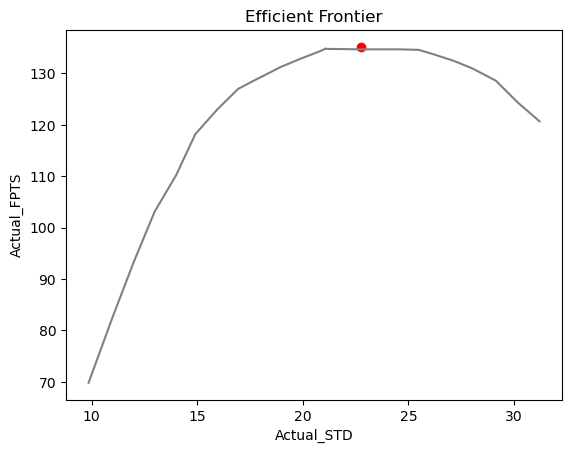

In [16]:
fig, ax = plt.subplots()
ax.plot(ef['Lower_STD'], ef['Lower_FPTS'], alpha=1, c='grey')
ax.plot(ef['Upper_STD'], ef['Upper_FPTS'], alpha=1, c='grey')

optimal = data[data['Optimal']==1]
ax.scatter((optimal['Actual_STD']**2).sum()**.5,
           optimal['FPTS'].sum(),
           c = 'red')

ax.set(title='Efficient Frontier',
       xlabel='Actual_STD',
       ylabel='Actual_FPTS')

x = 0

Generate rosters while iteratively dropping.

In [17]:
rosters = pd.DataFrame(columns=['FPTS', 'STD'])

def summarizeRoster(df, roster_name):
    temp = df[df[roster_name]==1]
    fpts = temp['FPTS'].sum()
    std = (temp['Actual_STD']**2).sum()**.5
    return [round(fpts, 1), round(std, 2)]

# timer
start = datetime.now()

# intial solution
solveIP(data, display=False, roster_name='Roster0')
rosters.loc['Roster0'] = summarizeRoster(data, 'Roster0')
initial_solution = list(data[data['Optimal']==1]['Nickname'])

# create powerset
p_set = _powerset(initial_solution)

count = 1
for e in p_set:
    rname = f'Roster{count}'
    solveIP(data, dropped=e, display=False, roster_name=rname)
    # mark dropped players with -1
    data.loc[data['Nickname'].isin(list(e)), rname] = -1
    rosters.loc[rname] = summarizeRoster(data, rname)
    count += 1

# second iter
secondary_solution = list(data[data[f'Roster{count-1}']==1]['Nickname'])
p_set = _powerset(secondary_solution)
for e in p_set:
    rname = f'Roster{count}'
    solveIP(data, roster_name=rname, display=False,
            dropped=initial_solution + list(e))
    # mark dropped players with -1
    data.loc[data['Nickname'].isin(initial_solution + list(e)), rname] = -1
    rosters.loc[rname] = summarizeRoster(data, rname)
    count += 1

# third iter
tertiary_solution = list(data[data[f'Roster{count-1}']==1]['Nickname'])
p_set = _powerset(secondary_solution)
for e in p_set:
    rname = f'Roster{count}'
    solveIP(data, roster_name=rname, display=False,
            dropped=initial_solution + secondary_solution + list(e))
    # mark dropped players with -1
    data.loc[data['Nickname'].isin(initial_solution + secondary_solution + list(e)), rname] = -1
    rosters.loc[rname] = summarizeRoster(data, rname)
    count += 1
    
stop = datetime.now()
print(stop - start)

0:01:54.479982


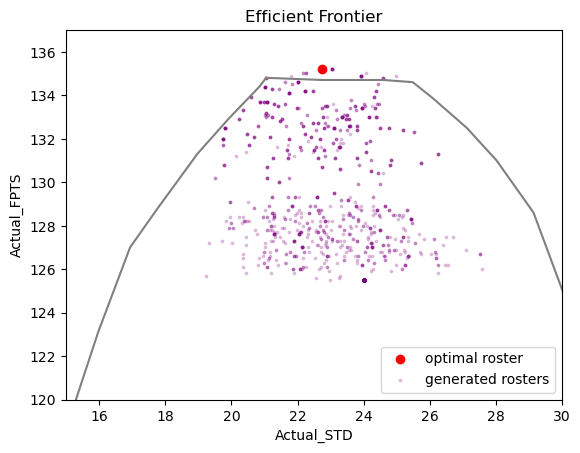

In [18]:
fig, ax = plt.subplots()

ax.scatter(rosters.loc['Roster0']['STD'],
           rosters.loc['Roster0']['FPTS'],
           c = 'red')

ax.scatter(rosters['STD'], rosters['FPTS'], alpha=.2, s=3,  c='purple')

ax.set(title='Efficient Frontier',
       xlabel='Actual_STD',
       ylabel='Actual_FPTS',
       xlim=[15, 30],
       ylim=[120, 137])

ax.plot(ef['Lower_STD'], ef['Lower_FPTS'], alpha=1, c='grey')
ax.plot(ef['Upper_STD'], ef['Upper_FPTS'], alpha=1, c='grey')

ax.legend(['optimal roster', 'generated rosters'], loc='lower right')
x = 0

In [19]:
q_fpts = rosters['FPTS'].quantile(.75)
q_std = rosters['STD'].quantile(1-.75)

# count appearances of players in data
start_ind = list(data.columns).index('Roster0')
data['Appearances'] = (data.iloc[:, start_ind:] > 0).sum(axis='columns')

# create dataframe of only top quantile rosters
top = rosters[(rosters['FPTS']>q_fpts) & (rosters['STD']<q_std)]

# add colomn for sum of appearances for each player in roster
scores = top.index.to_series().apply(lambda x: (data[x] * data['Appearances']).sum())
scores.name = 'Score'
top = pd.concat([top, scores], axis = 'columns')

In [20]:
# choose top scoring roster
selection = top.sort_values(['Score'], ascending=False).head(1)
selection

,FPTS,STD,Score
Roster8,134.6,22.01,4112.0


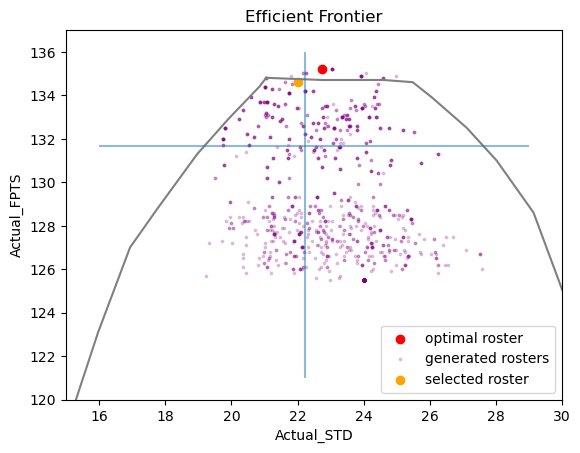

In [21]:
fig, ax = plt.subplots()

ax.scatter(rosters.loc['Roster0']['STD'],
           rosters.loc['Roster0']['FPTS'],
           c = 'red')

ax.scatter(rosters['STD'], rosters['FPTS'], alpha=.2, s=3,  c='purple')

ax.scatter(selection['STD'], selection['FPTS'], c = 'orange')

ax.set(title='Efficient Frontier',
       xlabel='Actual_STD',
       ylabel='Actual_FPTS',
       xlim=[15, 30],
       ylim=[120, 137])

ax.plot(ef['Lower_STD'], ef['Lower_FPTS'], alpha=1, c='grey')
ax.plot(ef['Upper_STD'], ef['Upper_FPTS'], alpha=1, c='grey')

ax.vlines(q_std, 121, 136, alpha=.5)
ax.hlines(q_fpts, 16, 29, alpha=.5)

ax.legend(['optimal roster', 'generated rosters', 'selected roster'], loc='lower right')
x = 0

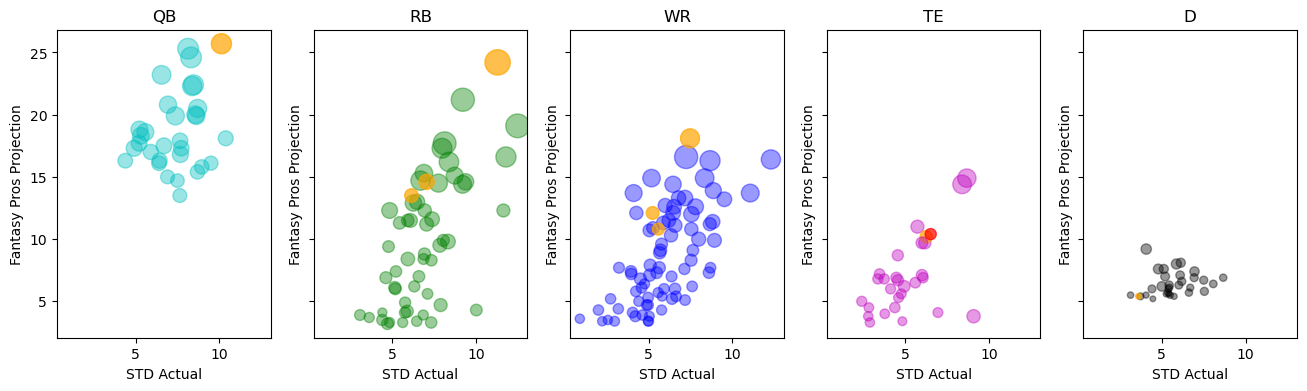

In [22]:
# selected roster
sel_name = selection.index[0]
chosen = data[data[sel_name] == 1]['Nickname'].to_list()
dropped = data[data[sel_name] == -1]['Nickname'].to_list()

colors = ['c', 'g', 'b', 'm', 'k']
fig, ax = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(16, 4))

for i, pos in enumerate(['QB', 'RB', 'WR', 'TE', 'D']):
    temp = data[data['Roster Position'].str.contains(pos)]

    ax[i].scatter(temp['Actual_STD'], temp['FPTS'],
                  s = (temp['Salary']/1000) ** 2.5,
                  c = temp[sel_name].map({-1:'r', 1:'orange', 0:colors[i]}),
                  alpha = temp[sel_name].map({-1:.7, 1:.7, 0:.4}),
                  label = pos)
    
    ax[i].set(xlabel = 'STD Actual', ylabel = 'Fantasy Pros Projection', title = pos)

In [23]:
data[data[sel_name] != 0][
    ['Nickname', 'Salary', 'Roster Position', 'Actual_STD', 'FPTS', sel_name]
].sort_values(sel_name, ascending=False)

,Nickname,Salary,Roster Position,Actual_STD,FPTS,Roster8
0,Jonathan Taylor,10200,RB/FLEX,11.296428,24.2,1.0
9,Lamar Jackson,8500,QB,10.125010,25.7,1.0
17,Justin Jefferson,8100,WR/FLEX,7.470654,18.1,1.0
61,Saquon Barkley,6800,RB/FLEX,7.060332,14.6,1.0
105,Javonte Williams,6200,RB/FLEX,6.156135,13.5,1.0
207,Allen Robinson II,5900,WR/FLEX,5.235866,12.1,1.0
219,Dallas Goedert,5700,TE/FLEX,6.260614,10.2,1.0
226,Brandon Aiyuk,5600,WR/FLEX,5.578825,10.8,1.0
1059,Las Vegas Raiders,3000,DEF,3.612478,5.4,1.0
269,Dalton Schultz,5300,TE/FLEX,6.522266,10.4,-1.0
